# Topic modelling of Alexa interactions 

Copyright 2023 Maria Lima  
(mr3418@ic.ac.uk)

Last updated: 10/06/2023

Analysis steps:
1. we used the pre-trained language model SentenceTransformer to embed each user utterance to a 768-dimensional vector. 
2. we applied 2 rounds of K-Means clustering model on the obtained utterance vectors. 
3. we applied the first K-Means clustering model to cluster the utterances into 16 clusters (silhoette score).
4. we manually identified a cluster that contained generic utterances (*the undefined topic*).
5. we identified and combined the clusters that contained similar topics into single clusters, resulting in a total of 8 clusters, including the undefined topic cluster.
6. we applied a second K-Means clustering model (using the same hyper-parameters) to cluster the undefined cluster into 15 topic clusters
7. we merged the similar topics from the second K-Means clustering with the first 7 topics identified
8. we added two newly emerged clusters and identified the new ”undefined” topic cluster
9. in total, we we identified 10 topics from Alexa interaction utterances from all the participants

### Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import ipynb
from utils import alexa_usage as ale
from utils import topic_modelling as top

### Load and process data

In [18]:
PATH = './datasets/'
df_topics_ = pickle.load(open(PATH + 'df_embeddings.pkl', 'rb'))
df_topics_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6967 entries, 0 to 6966
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   patient_id  6967 non-null   object        
 1   timeframe   6967 non-null   datetime64[ns]
 2   int_type    6967 non-null   object        
 3   embeddings  6967 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 217.8+ KB


In [19]:
df_topics_.head()

,patient_id,timeframe,int_type,embeddings
0,P1,2021-05-07 15:14:00,r,"[-0.03394558, -0.034660265, 0.022776427, 0.000..."
1,P1,2021-05-07 15:15:00,r,"[-0.037213616, -0.016807973, -0.00537387, 0.00..."
2,P1,2021-05-07 15:15:00,r,"[0.048271265, 0.09790515, -0.026405882, -0.017..."
3,P1,2021-05-07 15:15:00,r,"[-0.047362775, 0.09231143, 0.00047918205, -0.0..."
4,P1,2021-05-07 15:16:00,r,"[-0.010677358, 0.008209975, -0.0072758957, 0.0..."


In [20]:
df_topics_.patient_id.unique()

array(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14'], dtype=object)

### Comparing clustering methods

In [22]:
X = np.stack(df_topics_['embeddings'].values)
X

array([[-0.03394558, -0.03466026,  0.02277643, ..., -0.00872179,
        -0.04161463,  0.01259778],
       [-0.03721362, -0.01680797, -0.00537387, ..., -0.02326424,
        -0.02841421,  0.0325862 ],
       [ 0.04827126,  0.09790515, -0.02640588, ...,  0.00878272,
        -0.03873785, -0.01207158],
       ...,
       [-0.07203204,  0.01885381, -0.01158352, ...,  0.02054282,
        -0.02740985, -0.05036382],
       [-0.00691014,  0.13740782, -0.02536329, ..., -0.03653494,
         0.00516627, -0.01014439],
       [ 0.00954263,  0.04529433, -0.05402762, ...,  0.0292752 ,
        -0.0587127 ,  0.02169537]], dtype=float32)

In [23]:
# using kmeans
df_all_pred, count_all = top.get_topics(df_topics_, 'kmeans')

Clustering method used: kmeans
6 topics: silhouette score = 0.25564950704574585
7 topics: silhouette score = 0.2690649628639221
8 topics: silhouette score = 0.2803632915019989
9 topics: silhouette score = 0.2967197597026825
10 topics: silhouette score = 0.3091040849685669
11 topics: silhouette score = 0.3034748435020447
12 topics: silhouette score = 0.30943232774734497
13 topics: silhouette score = 0.3158341348171234
14 topics: silhouette score = 0.32106709480285645
15 topics: silhouette score = 0.31782659888267517
16 topics: silhouette score = 0.32347044348716736
17 topics: silhouette score = 0.3290840685367584
--->
The silhouette score is the highest (0.3290840685367584) for 17 topics.


In [24]:
np.random.seed(2023)
# Assuming df_topics is your DataFrame and embeddings is the column with the 768-d vectors
X = np.stack(df_topics_['embeddings'].values)
n_clusters = 16 # silhouette method
clusterings = [
    ('KMeans', KMeans(n_clusters=n_clusters)),  # chosen k
    # ('DBSCAN', DBSCAN(eps=0.5)),  # replace 0.5 with appropriate epsilon
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=n_clusters)),  # chosen k
    ('GMM', GaussianMixture(n_components=n_clusters)),  # chosen k
    ('SpectralClustering', SpectralClustering(n_clusters=n_clusters)), # chosen k
]

for name, algorithm in clusterings:
    # Fit the algorithm to the data
    if name == 'GMM':
        preds = algorithm.fit_predict(X)
    else:
        algorithm.fit(X)
        preds = algorithm.labels_
        
    # Calculate silhouette score
    score = "{:.4f}".format(silhouette_score(X, preds))
    print(f'Silhouette score for {name}: {score}')

Silhouette score for KMeans: 0.3255
Silhouette score for AgglomerativeClustering: 0.3170
Silhouette score for GMM: 0.3081
Silhouette score for SpectralClustering: 0.3173


### Clustering topics

In [26]:
embed = [] 
for i in np.array(df_topics_.embeddings):
    embed.append(list(i))
clusters = top.cluster_kmeans(16, embed) # 16 topics
clusters

array([10,  6,  7, ..., 12,  5,  4], dtype=int32)

In [30]:
df_clustered = df_topics_.copy()
df_clustered['pred'] = pd.Series(clusters)
# 16 TOPICS 
topic = np.unique(clusters)
count = {}
for i in topic:
    freq = len(df_clustered.loc[clusters == i])
    count[i] = freq
{k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}

{1: 1217,
 7: 1098,
 12: 942,
 2: 603,
 5: 425,
 9: 414,
 10: 311,
 8: 305,
 13: 284,
 11: 275,
 6: 250,
 4: 248,
 0: 225,
 3: 221,
 14: 86,
 15: 63}

In [31]:
df_clustered.head()

,patient_id,timeframe,int_type,embeddings,pred
0,P1,2021-05-07 15:14:00,r,"[-0.03394558, -0.034660265, 0.022776427, 0.000...",10
1,P1,2021-05-07 15:15:00,r,"[-0.037213616, -0.016807973, -0.00537387, 0.00...",6
2,P1,2021-05-07 15:15:00,r,"[0.048271265, 0.09790515, -0.026405882, -0.017...",7
3,P1,2021-05-07 15:15:00,r,"[-0.047362775, 0.09231143, 0.00047918205, -0.0...",5
4,P1,2021-05-07 15:16:00,r,"[-0.010677358, 0.008209975, -0.0072758957, 0.0...",11


#### Checking outliers (topic Undefined)

In [32]:
np.random.seed(2023)
# topic: new_topic
merged = {
    0: 0, # answers
    1: 1, # control commands
    2: 2, # entertainment (radio/music/games)
    3: 3, # timers
    4: 1, # control commands
    5: 2, # entertainment
    6: 4, # weather
    7: 5, # general/OUTLIERS
    8: 1, # control commands
    9: 6, # attempt questionnaire
    10: 7, # time/date/reminders
    11: 2, # entertainment
    12: 5, # general/OUTLIERS
    13: 2, # entertainment
    14: 0, # answers
    15: 2, # entertainment
}

df_clustered_merged = df_clustered.replace({"pred": merged})
# check general outliers
embed_general = df_clustered_merged[df_clustered_merged.pred == 5] # check OK
len(embed_general)

2040

In [33]:
df_clustered_merged.head()

,patient_id,timeframe,int_type,embeddings,pred
0,P1,2021-05-07 15:14:00,r,"[-0.03394558, -0.034660265, 0.022776427, 0.000...",7
1,P1,2021-05-07 15:15:00,r,"[-0.037213616, -0.016807973, -0.00537387, 0.00...",4
2,P1,2021-05-07 15:15:00,r,"[0.048271265, 0.09790515, -0.026405882, -0.017...",5
3,P1,2021-05-07 15:15:00,r,"[-0.047362775, 0.09231143, 0.00047918205, -0.0...",2
4,P1,2021-05-07 15:16:00,r,"[-0.010677358, 0.008209975, -0.0072758957, 0.0...",2


#### Kmeans on outliers (topic Undefined)

In [36]:
# run kmeans on outliers 
embed = [] 
for i in np.array(embed_general.embeddings):
    embed.append(list(i))
clusters_general = top.cluster_kmeans(15, embed) # 15 topics

embed_general_ = embed_general.copy()
embed_general_ = embed_general_.reset_index(drop=True)
embed_general_['pred_merged'] = pd.Series(clusters_general)
embed_general_.pred_merged = np.nan_to_num(embed_general_.pred_merged).astype(int)
embed_general_.head()

,patient_id,timeframe,int_type,embeddings,pred,pred_merged
0,P1,2021-05-07 15:15:00,r,"[0.048271265, 0.09790515, -0.026405882, -0.017...",5,2
1,P1,2021-05-07 15:17:00,r,"[-0.014381975, -0.017219102, 0.0065887617, 2.2...",5,14
2,P1,2021-05-07 15:19:00,r,"[-0.01720514, -0.0039791097, -0.016143542, 0.0...",5,1
3,P1,2021-05-07 15:23:00,r,"[0.005988242, -0.0045428593, -0.04481511, 0.03...",5,2
4,P1,2021-05-07 15:25:00,r,"[0.022044094, -0.027473543, 0.010056915, 0.036...",5,11


In [37]:
# 15  TOPICS 
topic = np.unique(clusters_general)
count_general = {}
for i in topic:
    freq = len(embed_general_.loc[clusters_general == i])
    count_general[i] = freq
{k: v for k, v in sorted(count_general.items(), key=lambda item: item[1], reverse=True)}

{0: 513,
 11: 307,
 5: 236,
 2: 196,
 8: 168,
 14: 151,
 13: 97,
 10: 76,
 4: 73,
 1: 52,
 12: 51,
 3: 40,
 9: 31,
 7: 27,
 6: 22}

#### Merge similar topics to clustering round 1

In [38]:
# topic: new_topic
merged_general = {
    0: 5, # general
    1: 6, # attempt questionnaire
    2: 5, # general
    3: 0, # answers
    4: 1, # control commands
    5: 5, # general
    6: 5, # general
    7: 0, # answers
    8: 8, # NEWS --> NEW TOPIC!!
    9: 0, # answers
    10: 9, # GREETING --> NEW TOPIC!!
    11: 5, # general
    12: 0, # answers
    13: 1, # control commands
    14: 5, # general
}

pred_general_merged = embed_general_.copy()
pred_general_merged = pred_general_merged.replace({"pred_merged": merged_general})
pred_general_merged.head()

,patient_id,timeframe,int_type,embeddings,pred,pred_merged
0,P1,2021-05-07 15:15:00,r,"[0.048271265, 0.09790515, -0.026405882, -0.017...",5,5
1,P1,2021-05-07 15:17:00,r,"[-0.014381975, -0.017219102, 0.0065887617, 2.2...",5,5
2,P1,2021-05-07 15:19:00,r,"[-0.01720514, -0.0039791097, -0.016143542, 0.0...",5,6
3,P1,2021-05-07 15:23:00,r,"[0.005988242, -0.0045428593, -0.04481511, 0.03...",5,5
4,P1,2021-05-07 15:25:00,r,"[0.022044094, -0.027473543, 0.010056915, 0.036...",5,5


In [39]:
# exclude rows with pred==5 (the undefined topic)
df_clustered_merged_ = df_clustered_merged.copy()
df_clustered_merged_ = df_clustered_merged_[df_clustered_merged_.pred != 5]
len(df_clustered_merged_)

4927

In [41]:
# drop column
pred_general_merged.drop('pred', axis=1, inplace=True)
pred_general_merged.rename(columns={'pred_merged':'pred'}, inplace=True)
df_final = pd.concat([df_clustered_merged_,pred_general_merged], axis=0).sort_values(['patient_id','timeframe']).reset_index(drop=True)
df_final

,patient_id,timeframe,int_type,embeddings,pred
0,P1,2021-05-07 15:14:00,r,"[-0.03394558, -0.034660265, 0.022776427, 0.000...",7
1,P1,2021-05-07 15:15:00,r,"[-0.037213616, -0.016807973, -0.00537387, 0.00...",4
2,P1,2021-05-07 15:15:00,r,"[-0.047362775, 0.09231143, 0.00047918205, -0.0...",2
3,P1,2021-05-07 15:15:00,r,"[0.048271265, 0.09790515, -0.026405882, -0.017...",5
4,P1,2021-05-07 15:16:00,r,"[-0.010677358, 0.008209975, -0.0072758957, 0.0...",2
...,...,...,...,...,...
6962,P9,2021-12-19 14:16:00,r,"[0.022635322, 0.047810424, -0.016858222, -0.02...",5
6963,P9,2021-12-19 14:17:00,r,"[0.022635322, 0.047810424, -0.016858222, -0.02...",5
6964,P9,2021-12-19 14:17:00,r,"[-0.025171185, 0.041670192, -0.00047654493, -0...",5
6965,P9,2021-12-19 14:17:00,r,"[0.025658667, 0.04192082, -0.004435441, 0.0277...",5


### Cluster visualization

/Users/mr3418/opt/anaconda3/envs/minder_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


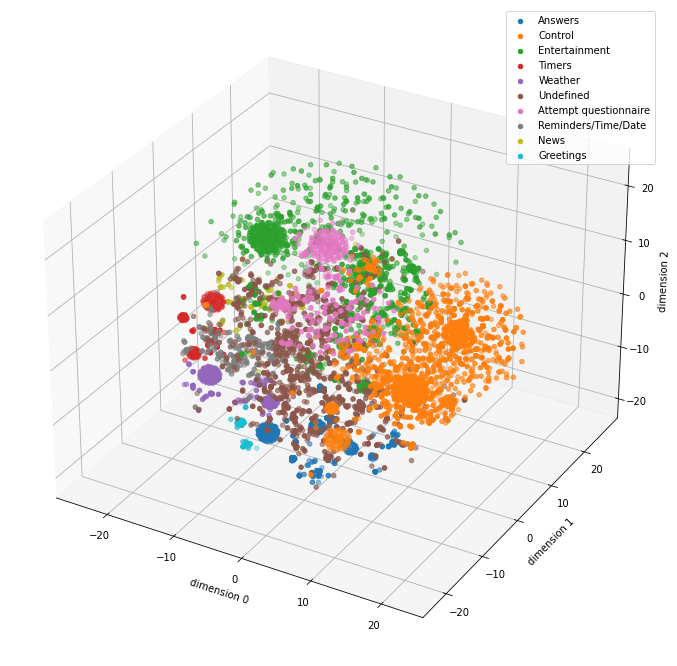

In [44]:
df_tsne = top.get_tsne(df_final,3)
top.plot3d(df_tsne)

/Users/mr3418/opt/anaconda3/envs/minder_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


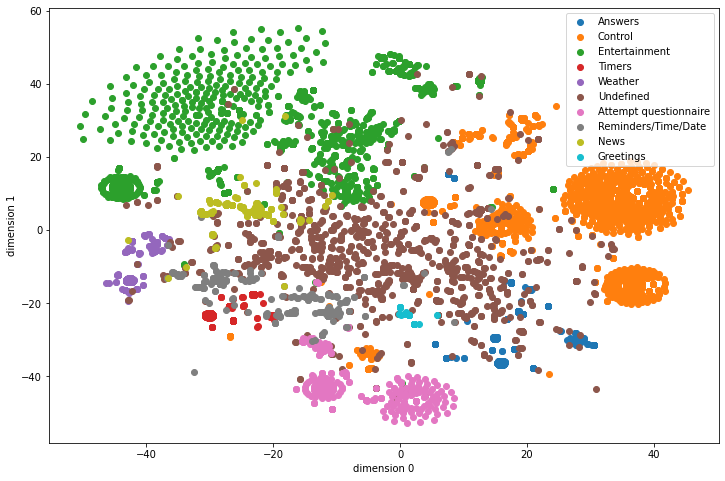

In [45]:
df_tsne = top.get_tsne(df_final,2)
top.plot2d(df_tsne,0,1)

/Users/mr3418/opt/anaconda3/envs/minder_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


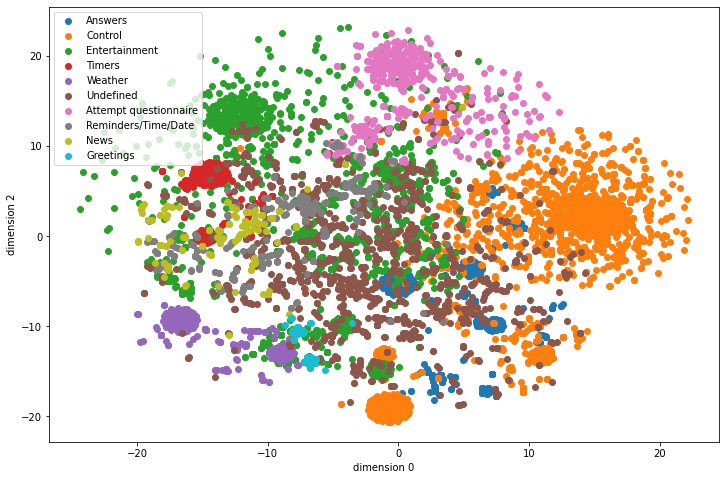

In [47]:
df_tsne = top.get_tsne(df_final,3)
top.plot2d(df_tsne,0,2)